In [1]:
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.utils import shuffle
import re
import os

def find_checkpoint(checkpoint_format):
    checkpoint_pattern = re.compile(checkpoint_format.replace('{epoch:04d}', '(\d+)'))
    checkpoint_files = [file for file in os.listdir('.') if os.path.isfile(file) and checkpoint_pattern.match(file)]

    if checkpoint_files:
        checkpoint_epochs = [int(checkpoint_pattern.search(file).group(1)) for file in checkpoint_files]
        return checkpoint_files, checkpoint_epochs
    else:
        return None, 0

model_name = 'output_mag'
checkpoint_filenames, epochs = find_checkpoint(f'{model_name}_checkpoint_{"{epoch:04d}"}.hdf5')
checkpoint_filenames, epochs

2024-02-01 20:30:37.335568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 20:30:37.335615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 20:30:37.336399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 20:30:37.341859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 20:30:38.020154: W tensorflow/compiler/tf2

(['output_mag_checkpoint_0050.hdf5',
  'output_mag_checkpoint_0100.hdf5',
  'output_mag_checkpoint_0150.hdf5',
  'output_mag_checkpoint_0200.hdf5',
  'output_mag_checkpoint_0250.hdf5',
  'output_mag_checkpoint_0300.hdf5',
  'output_mag_checkpoint_0400.hdf5',
  'output_mag_checkpoint_0450.hdf5',
  'output_mag_checkpoint_0500.hdf5'],
 [50, 100, 150, 200, 250, 300, 400, 450, 500])

In [2]:
import numpy as np

from dataset import *
from model import *
from util import *

np.random.seed(0)

window_size = 200
stride = 10

x_gyro = []
x_acc = []
x_mag = []

y_delta_p = []
y_delta_q = []

imu_data_filenames = []
gt_data_filenames = []

imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/imu1.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu4.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/imu4.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu7.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/imu4.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/imu5.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu1.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu5.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu4.csv')

gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/vi1.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi4.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/vi4.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi7.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/vi4.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/vi5.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi1.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi5.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi4.csv')

for i, (cur_imu_data_filename, cur_gt_data_filename) in enumerate(zip(imu_data_filenames, gt_data_filenames)):
    cur_gyro_data, cur_acc_data, mag_data, cur_pos_data, cur_ori_data = load_oxiod_dataset(cur_imu_data_filename, cur_gt_data_filename)

    [cur_x_gyro, cur_x_acc, curr_x_mag], [cur_y_delta_p, cur_y_delta_q], init_p, init_q = load_dataset_6d_quat(cur_gyro_data, cur_acc_data, mag_data, cur_pos_data, cur_ori_data, window_size, stride)

    x_gyro.append(cur_x_gyro)
    x_acc.append(cur_x_acc)
    x_mag.append(curr_x_mag)

    y_delta_p.append(cur_y_delta_p)
    y_delta_q.append(cur_y_delta_q)
    
x_gyro = np.vstack(x_gyro)
x_acc = np.vstack(x_acc)
x_mag = np.vstack(x_mag)

y_delta_p = np.vstack(y_delta_p)
y_delta_q = np.vstack(y_delta_q)

x_gyro.shape

(61115, 200, 3)

In [10]:

checkpoint_loss = []

for checkpoint_name, epoch in zip(checkpoint_filenames, epochs):
    model = load_model(checkpoint_name, custom_objects={'CustomMultiLossLayer': CustomMultiLossLayer})
    # pred_model = create_pred_model_6d_quat(window_size, mag=True)
    # pred_model.set_weights(model.get_weights()[:-2])
    print(f'pred model loaded from {checkpoint_name}')
    loss = model.predict([x_gyro, x_acc, x_mag, y_delta_p, y_delta_q], batch_size=1024, verbose=1)
    checkpoint_loss.append([epoch, loss.mean()])

pred model loaded from output_mag_checkpoint_0050.hdf5
60/60 [==============================] - 5s 59ms/step
pred model loaded from output_mag_checkpoint_0100.hdf5
60/60 [==============================] - 5s 60ms/step
pred model loaded from output_mag_checkpoint_0150.hdf5
60/60 [==============================] - 5s 60ms/step
pred model loaded from output_mag_checkpoint_0200.hdf5
60/60 [==============================] - 5s 60ms/step
pred model loaded from output_mag_checkpoint_0250.hdf5
60/60 [==============================] - 5s 60ms/step
pred model loaded from output_mag_checkpoint_0300.hdf5
60/60 [==============================] - 5s 60ms/step
pred model loaded from output_mag_checkpoint_0400.hdf5
60/60 [==============================] - 5s 59ms/step
pred model loaded from output_mag_checkpoint_0450.hdf5
60/60 [==============================] - 5s 59ms/step
pred model loaded from output_mag_checkpoint_0500.hdf5
60/60 [==============================] - 5s 59ms/step


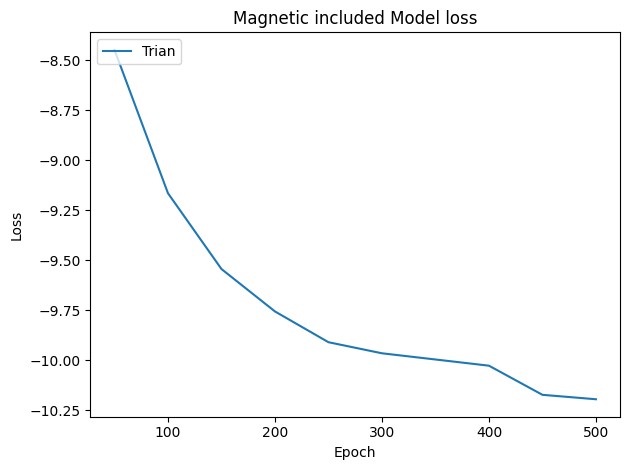

In [41]:
plt_loss = np.array(checkpoint_loss)
plt.style.use('default')
plt.plot(plt_loss[:, 0], plt_loss[:, 1])
plt.title('Magnetic included Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Trian'], loc='upper left')
plt.tight_layout()
plt.savefig('loss_mag.png')

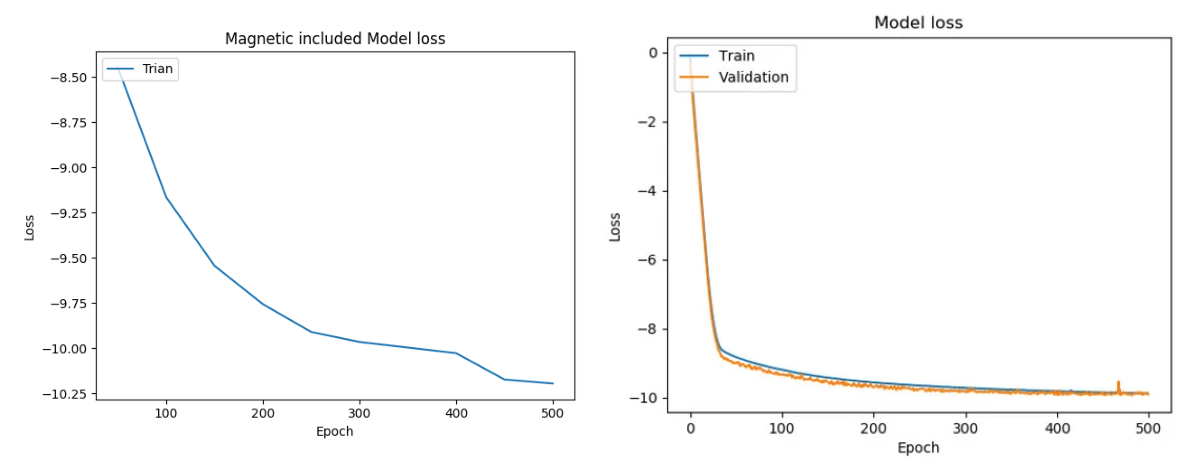

In [42]:
f, ax  = plt.subplots(1,2, figsize=(12, 10), tight_layout=True)
im1 = plt.imread('loss_mag.png')
im2 = plt.imread('model_no_mag.webp')
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.savefig('final.png')
